In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import xgboost 
from sklearn import set_config
set_config(transform_output="pandas")


In [2]:
data_path = "Dataset_analyse.csv"
df = pd.read_csv(data_path)

df = df.drop(['month','genre_raw','month_name','raw_title','actor_list','budget','rating_press','day',"total_spectator",'distributor','classification_country','country','director',"hebdo_rank","first_day","first_weekend","casting","award","lang"], axis=1)
df = df.dropna()

df

,year,genre,duration,first_week,copies,director_combined_score,entree_annee,distributor_combined_score,year_combined_score,country_combined_score,total_actor_scores,season,is_holiday
0,2008,"[""comedie"", ""romantique""]",6360,4378720,793,0.552291,190.3,0.708905,0.847850,0.718999,0.557049,winter,0
1,2006,"[""comedie""]",5820,3906694,950,0.291469,188.8,0.594723,0.872062,0.718999,0.529809,winter,0
2,2000,"[""action"", ""comedie"", ""policier""]",5400,3478850,831,0.458344,165.8,0.542576,0.776540,0.718999,0.454720,spring,0
3,2005,"[""action"", ""aventure"", ""fantastique""]",8760,3303005,938,0.577991,175.6,0.519549,0.832416,0.918252,0.967593,spring,0
4,2019,"[""animation"", ""aventure"", ""drame""]",7080,3252896,680,0.354940,213.2,0.490656,0.841668,0.918252,0.524373,summer,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,1998,"[""drame"", ""mystere"", ""thriller""]",6600,49321,49,0.171094,170.6,0.041582,0.692529,0.918252,0.292473,winter,0
2660,2017,"[""animation"", ""aventure"", ""comedie""]",5280,48816,267,0.050555,209.4,0.092873,0.837955,0.718999,0.895385,winter,0
2663,2006,"[""comedie"", ""drame"", ""romantique""]",6120,48535,86,0.152125,188.8,0.049224,0.872062,0.918252,0.246057,autumn,0
2669,2013,"[""drame""]",8460,47900,81,0.182009,193.7,0.048940,0.831473,0.341090,0.292652,spring,0


In [3]:
X = df.drop(['first_week'], axis=1)
y = df.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

onehotscale_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)

polyscale_pipeline = make_pipeline(PolynomialFeatures(2))

my_final_pipeline = make_pipeline(preprocessing)#, polyscale_pipeline)
my_final_pipeline.fit(X_train)

feature_names = my_final_pipeline.get_feature_names_out(X.columns)

In [4]:
# from sklearn import set_config


# set_config(transform_output="pandas")
# model = make_pipeline(
#     my_final_pipeline,
# )
# xdata = model.fit_transform(X_train, y_train)
# xdata.head()

In [5]:
model = make_pipeline(
    my_final_pipeline,
    xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    )

model.fit(X_train, y_train)

ValueError: feature_names must be string, and may not contain [, ] or <

In [ ]:
# pyplot.bar(range(len(model[-1].feature_importances_)), model[-1].feature_importances_)
# pyplot.show()

In [ ]:
xtrain_tr = model[:-1].fit_transform(X_train)

In [ ]:
xtrain_tr.columns

Index(['categorical__season_autumn', 'categorical__season_spring',
       'categorical__season_summer', 'categorical__season_winter',
       'numerical__year', 'numerical__duration', 'numerical__copies',
       'numerical__director_combined_score', 'numerical__entree_annee',
       'numerical__distributor_combined_score',
       'numerical__year_combined_score', 'numerical__country_combined_score',
       'numerical__total_actor_scores', 'numerical__is_holiday'],
      dtype='object')

In [ ]:
# pd.Series(model[-1].feature_importances_, index = xtrain_tr.columns)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

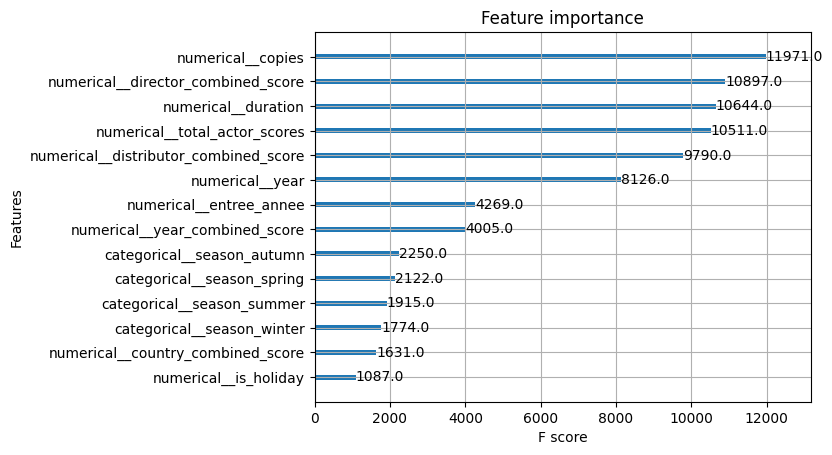

In [ ]:
xgboost.plot_importance(model[-1], max_num_features=20)

In [ ]:
# y_pred_train = model.predict(X_train)


# residus =  y_pred_train - y_train


# weights = np.exp(-abs(residus) / residus.std())
# model.fit(X_train, y_train, lasso__sample_weight=weights)




y_pred = model.predict(X_test)
# y_pred = model.predict(df_test)
# print(y_pred)

In [ ]:

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

Performance du modèle :
R2 Score: 0.8200
MAE: 76089.23
RMSE: 164727.00


In [ ]:
from joblib import dump, load

model_path = 'model.pkl'
dump(model, model_path)
model = load('model.pkl')

In [ ]:
def predict_prod(model,data):
    # Convertir la liste de listes en DataFrame
    df = pd.DataFrame(data, columns=['year','season', 'entree_annee','is_holiday','month','day','director', 'country','classification_country','classification_acteurs' ,'duration', 'genre', 'copies', 'rating_press','budget','distributor'])
    predictions = model.predict(df)
    return predictions

predict_prod(model,[[2024,'spring', 180.8,1,3, 8,2, "etatsunis",3,3, 5640, "animation", 696, 3.4, 85000000, 3]])

ValueError: columns are missing: {'director_combined_score', 'country_combined_score', 'distributor_combined_score', 'year_combined_score', 'total_actor_scores'}